In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# %cd /content/drive/MyDrive/Term 8/Term 8 Artificial Intelligence/folder
%cd /content/drive/MyDrive/AI/CellCount

/content/drive/.shortcut-targets-by-id/1M3QhWnNQxBOjigeJQSrbL_OSx3OjxOSV/AI/CellCount


In [3]:
!git clone https://github.com/Bjarten/early-stopping-pytorch.git ./earlystopping

fatal: destination path './earlystopping' already exists and is not an empty directory.


In [4]:
!pip install efficientnet_pytorch

In [5]:
import os
import torch
import datetime
from efficientnet_pytorch import EfficientNet
from model import *
from utils import *
import numpy as np
from tqdm import tqdm
from PIL import Image
from skimage import io
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.io import loadmat, savemat
from torch.utils.data import Dataset, DataLoader
from earlystopping.pytorchtools import EarlyStopping
from torch.utils.data.sampler import SubsetRandomSampler

# Dataset and Dataloader

In [6]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

class CellDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        self.fileNames = [i[:-4] for i in sorted(os.listdir(root_dir+"/Labels/"))]
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fileNames)
    
    """
    returns: tuple of
    - image
    - mask of size n x n with unique values/classes ranging from 0 to 4 
        0: background
        1: others (1)
        2: inflammatory(2)
        3: healthy epithelial(3) , dysplastic/malignant epithelial(4)
        4: fibroblast(5) , muscle(6) , endothelial(7)
    """
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,"Images",self.fileNames[idx])+".png"
        image = img = Image.open(img_name).convert('RGB')
        mask_name = os.path.join(self.root_dir,"Labels",self.fileNames[idx])+".mat"
        x = loadmat(mask_name)['type_map']
        x[(x==3)|(x==4)]=3
        x[(x==5)|(x==6)|(x==7)]=4

        # 250x250 images
        # x=np.pad(x.astype(int),3)

        # 500x500 images
        x=np.pad(x.astype(int),6)

        # 1000x1000 images
        # x=np.pad(x.astype(int),12)

        if self.transform:
            image = self.transform(image)
        return image, to_categorical(x,5).transpose(2, 0, 1) #(num_classes=5, n, n)

In [7]:
transform = transforms.Compose([
    # 250x250 images
    # transforms.Pad(3),

    # 500x500 images
    transforms.Pad(6),

    # 1000x1000 images
    # transforms.Pad(12),
    
    transforms.ToTensor()    
])

valid_size = 0.2
batch_size =1

# DataLoader
train_data = CellDataset(root_dir="../Train/train_500", transform = transform)
test_data = CellDataset(root_dir="../Test/test_500", transform = transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# load training data in batches
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=train_sampler,
                          num_workers=0)

# load validation data in batches
valid_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          sampler=valid_sampler,
                          num_workers=0)

# load test data in batches
test_loader = DataLoader(test_data,
                        batch_size=batch_size,
                        num_workers=0)

## Training

In [8]:
def weighted_loss(pred,targ,bce_weight=0.5, smooth=1.):
    
    bce = F.binary_cross_entropy_with_logits(pred.squeeze(dim=1), targ)
    
    pred = torch.sigmoid(pred)
    
    pred = pred.contiguous().squeeze(dim=1)  
    targ = targ.contiguous()  

    intersection = (pred * targ).sum(dim=1).sum(dim=1)
    dice = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + targ.sum(dim=1).sum(dim=1) + smooth)))
    
    loss = bce * bce_weight + dice.mean() * (1 - bce_weight)
    
    return loss

def train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name):
    train_losses = []
    valid_losses = []
    avg_train_losses = [] # average training loss per epoch
    avg_valid_losses = [] # average validation loss per epoch
    valid_acc = 0
    
    os.makedirs("best_model_checkpoints", exist_ok=True)
    os.makedirs("model_checkpoints", exist_ok=True)
    save_path = f"best_model_checkpoints/{model.__class__.__name__}.pth"
    early_stopping = EarlyStopping(patience=patience, path=save_path, verbose=True)
    for epoch in tqdm(range(1, epochs + 1)):
        train_loss = 0
        valid_loss = 0
        score = 0
        """
        Trains the model on training data
        """
        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()
            data, target = data.to(device), target.to(device).float()

            optimizer.zero_grad()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.5)
            loss.backward()
            optimizer.step()

            train_loss+=(loss/len(data)).item()
            train_losses.append(loss.item())
            # Find accuracy
        
        """
        Validate the model on validation data
        """
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device).float()
            output = model(data)
            loss = weighted_loss(output,target,bce_weight=0.3)
            valid_loss+=(loss/len(data)).item()
            valid_losses.append(loss.item())
            pred = output[0].to('cpu').detach()
            pred=F.softmax(pred, dim=0)# along the channel
            pred=pred.numpy()
            pred[pred.max(axis=0,keepdims=1) == pred] = 1
            pred[pred.max(axis=0,keepdims=1) != pred] = 0
            score+=get_dice_1(target, pred)

        train_loss /= len(train_loader)
        valid_loss /= len(valid_loader)
        score /= len(valid_loader)
        if score > valid_acc:
            valid_acc = score

        # average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        torch.save(model.state_dict(), f"model_checkpoints/{model.__class__.__name__}_{model_chkpt_name}_{epoch}.pth")
        print('Train Epoch: {} @ {} - Train Loss: {:.4f} - Valid Loss: {:.4f}'.format(epoch, datetime.datetime.now().time(), train_loss, valid_loss))

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load(save_path)) 

    return  model, avg_train_losses, avg_valid_losses, valid_acc

In [9]:
# Set cpu / gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = build_model(device, "efficientnet", EfficientNet)
model.to(device)

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

Loaded pretrained weights for efficientnet-b7


In [10]:
# Training the model
print("Training")

epochs = 100
patience = 10  # how long to wait after last time validation loss improved
model_chkpt_name = "EfficientNet-500x500"

model, train_loss, valid_loss, valid_acc = train(model, device, train_loader, valid_loader, optimizer, epochs, patience, model_chkpt_name)

  0%|          | 0/100 [00:00<?, ?it/s]

Training


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validation loss decreased (inf --> 0.165299).  Saving model ...


  1%|          | 1/100 [06:25<10:36:16, 385.62s/it]

Train Epoch: 1 @ 13:41:42.587960 - Train Loss: 0.2637 - Valid Loss: 0.1653
Validation loss decreased (0.165299 --> 0.154565).  Saving model ...


  2%|▏         | 2/100 [09:09<8:41:25, 319.24s/it] 

Train Epoch: 2 @ 13:44:26.951185 - Train Loss: 0.1567 - Valid Loss: 0.1546
Validation loss decreased (0.154565 --> 0.124504).  Saving model ...


  3%|▎         | 3/100 [11:53<7:20:33, 272.51s/it]

Train Epoch: 3 @ 13:47:10.430446 - Train Loss: 0.1416 - Valid Loss: 0.1245
Validation loss decreased (0.124504 --> 0.114186).  Saving model ...


  4%|▍         | 4/100 [14:37<6:23:47, 239.87s/it]

Train Epoch: 4 @ 13:49:54.126515 - Train Loss: 0.1324 - Valid Loss: 0.1142
Validation loss decreased (0.114186 --> 0.111383).  Saving model ...


  5%|▌         | 5/100 [17:20<5:43:40, 217.06s/it]

Train Epoch: 5 @ 13:52:37.959282 - Train Loss: 0.1241 - Valid Loss: 0.1114
Validation loss decreased (0.111383 --> 0.104573).  Saving model ...


  6%|▌         | 6/100 [20:05<5:15:07, 201.15s/it]

Train Epoch: 6 @ 13:55:21.975581 - Train Loss: 0.1165 - Valid Loss: 0.1046
EarlyStopping counter: 1 out of 10


  7%|▋         | 7/100 [22:46<4:53:18, 189.23s/it]

Train Epoch: 7 @ 13:58:03.414827 - Train Loss: 0.1129 - Valid Loss: 0.1110
EarlyStopping counter: 2 out of 10


  8%|▊         | 8/100 [25:27<4:37:20, 180.87s/it]

Train Epoch: 8 @ 14:00:44.771606 - Train Loss: 0.1065 - Valid Loss: 0.1071
Validation loss decreased (0.104573 --> 0.096836).  Saving model ...


  9%|▉         | 9/100 [28:10<4:26:10, 175.50s/it]

Train Epoch: 9 @ 14:03:27.738167 - Train Loss: 0.1037 - Valid Loss: 0.0968
EarlyStopping counter: 1 out of 10


 10%|█         | 10/100 [30:52<4:17:11, 171.46s/it]

Train Epoch: 10 @ 14:06:09.763707 - Train Loss: 0.0981 - Valid Loss: 0.0975
EarlyStopping counter: 2 out of 10


 11%|█         | 11/100 [33:34<4:09:50, 168.44s/it]

Train Epoch: 11 @ 14:08:51.155632 - Train Loss: 0.0967 - Valid Loss: 0.0981
EarlyStopping counter: 3 out of 10


 12%|█▏        | 12/100 [36:15<4:04:01, 166.38s/it]

Train Epoch: 12 @ 14:11:32.742266 - Train Loss: 0.0898 - Valid Loss: 0.0973
Validation loss decreased (0.096836 --> 0.095124).  Saving model ...


 13%|█▎        | 13/100 [38:58<3:59:47, 165.37s/it]

Train Epoch: 13 @ 14:14:15.758395 - Train Loss: 0.0918 - Valid Loss: 0.0951
Validation loss decreased (0.095124 --> 0.091651).  Saving model ...


 14%|█▍        | 14/100 [41:42<3:56:28, 164.99s/it]

Train Epoch: 14 @ 14:16:59.847647 - Train Loss: 0.0794 - Valid Loss: 0.0917
EarlyStopping counter: 1 out of 10


 15%|█▌        | 15/100 [44:24<3:52:26, 164.07s/it]

Train Epoch: 15 @ 14:19:41.787769 - Train Loss: 0.0807 - Valid Loss: 0.1393
EarlyStopping counter: 2 out of 10


 16%|█▌        | 16/100 [47:06<3:48:31, 163.23s/it]

Train Epoch: 16 @ 14:22:23.050929 - Train Loss: 0.0892 - Valid Loss: 0.0953
EarlyStopping counter: 3 out of 10


 17%|█▋        | 17/100 [49:47<3:45:07, 162.74s/it]

Train Epoch: 17 @ 14:25:04.633552 - Train Loss: 0.0729 - Valid Loss: 0.0938
EarlyStopping counter: 4 out of 10


 18%|█▊        | 18/100 [52:29<3:42:03, 162.49s/it]

Train Epoch: 18 @ 14:27:46.535077 - Train Loss: 0.0705 - Valid Loss: 0.0925
EarlyStopping counter: 5 out of 10


 19%|█▉        | 19/100 [55:10<3:38:41, 162.00s/it]

Train Epoch: 19 @ 14:30:27.397979 - Train Loss: 0.0700 - Valid Loss: 0.1048
EarlyStopping counter: 6 out of 10


 20%|██        | 20/100 [57:51<3:35:40, 161.75s/it]

Train Epoch: 20 @ 14:33:08.569801 - Train Loss: 0.0702 - Valid Loss: 0.1168
EarlyStopping counter: 7 out of 10


 21%|██        | 21/100 [1:00:32<3:32:41, 161.54s/it]

Train Epoch: 21 @ 14:35:49.625075 - Train Loss: 0.0637 - Valid Loss: 0.1227
EarlyStopping counter: 8 out of 10


 22%|██▏       | 22/100 [1:03:13<3:29:55, 161.48s/it]

Train Epoch: 22 @ 14:38:30.956452 - Train Loss: 0.0604 - Valid Loss: 0.0929
EarlyStopping counter: 9 out of 10


 23%|██▎       | 23/100 [1:05:55<3:27:06, 161.39s/it]

Train Epoch: 23 @ 14:41:12.135744 - Train Loss: 0.0602 - Valid Loss: 0.1097
EarlyStopping counter: 10 out of 10
Early stopping


In [11]:
print("DICE score:", valid_acc)

DICE score: 0.923351005271629


# Graphs

In [12]:
def plot_graph(train_loss, valid_loss):
  fig = plt.figure(figsize=(10,8))
  plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
  plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

  # find position of lowest validation loss
  minposs = valid_loss.index(min(valid_loss))+1 
  plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.ylim(0, 0.5) # consistent scale
  plt.xlim(0, len(train_loss)+1) # consistent scale
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()
  fig.savefig('loss_plot.png', bbox_inches='tight')

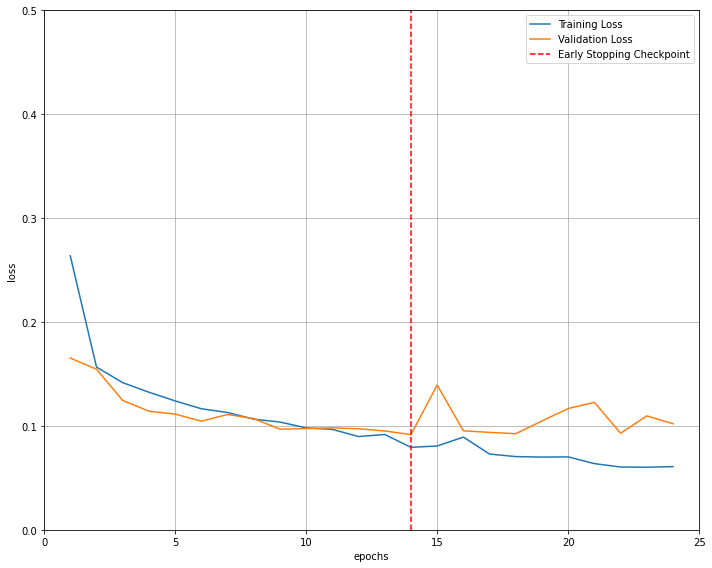

In [13]:
plot_graph(train_loss, valid_loss)

# Load model


In [14]:
# load saved model
def load_model(model):
  path = f"best_model_checkpoints/{model.__class__.__name__}.pth"
  model.load_state_dict(torch.load(path)) 
  model.eval()
  return model
model = load_model(model)

# Test

In [15]:
"""
0: black: background
1: red: others (1)
2: green: inflammatory(2)
3: dark blue: healthy epithelial(3) , dysplastic/malignant epithelial(4)
4: light blue: fibroblast(5) , muscle(6) , endothelial(7)
"""
# params: 5 x n x n numpy or n x n x 5
def printColoredMask(npMask,numchannel=5):
    if npMask.shape[-1]!=5:
        npMask=npMask.transpose(1, 2, 0)
    finalnpMask=np.where(npMask[:,:,1]==1,255,0) # one color
    finalnpMask=finalnpMask[:,:,None]
    temp=np.where((npMask[:,:,2]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    temp=np.where((npMask[:,:,3]==1)|(npMask[:,:,4]==1),255,0) # one color
    finalnpMask = np.concatenate((finalnpMask,temp[:, :, None]),axis=2)
    plt.imshow(finalnpMask)
    plt.show()

In [16]:
def test(model, device, data, target):
    print("Input Image")
    plt.imshow(data[0].numpy().transpose(1, 2, 0))
    plt.show()
    outputs = model(data.to(device))[0]
    pred = outputs.to('cpu').detach()
    pred=F.softmax(pred, dim=0)# along the channel
    pred=pred.numpy()

    print("Predicted Mask Sigmoid")
    pred[pred.max(axis=0,keepdims=1) == pred] = 1
    pred[pred.max(axis=0,keepdims=1) != pred] = 0
    printColoredMask(pred)
    print("Actual Mask")
    printColoredMask(target[0].numpy())

    # PQ
    pq_score = get_fast_pq(target, pred)[0]
    print("Detection Quality (DQ):", pq_score[0])
    print("Segmentation Quality (SQ):", pq_score[1])
    print("Panoptic Quality (PQ):", pq_score[2])
    
    dice_score = get_dice_1(target, pred)
    print("Dice score:", dice_score, "\n")

Input Image


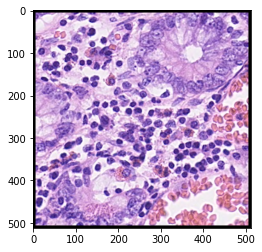

Predicted Mask Sigmoid


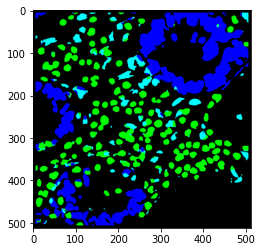

Actual Mask


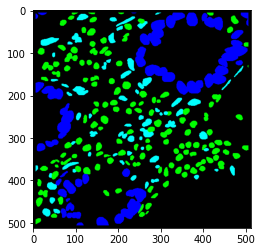

Detection Quality (DQ): 1.0
Segmentation Quality (SQ): 0.7833220623045641
Panoptic Quality (PQ): 0.7833220623045641
Dice score: 0.8784980773925781 



In [17]:
# Testing the model
for data, target in test_loader:
    test(model, device, data, target)
    break